# Get available credential

In [ ]:
import json

with open("/Users/ngdnhtien/.qiskit/qiskit-ibm.json", "r") as jF:
    credential = json.load(jF)

with open("/Users/ngdnhtien/.qiskit/bank.json", "r") as bank:
    credential_bank = json.load(bank)

credential_bank = {key: value for key, value in credential_bank.items() if value['capacity'] == "full"}
token_available = next(iter(credential_bank))

credential['default-ibm-quantum']['token'] = credential_bank[token_available]['token']

with open("/Users/ngdnhtien/.qiskit/qiskit-ibm.json", "w") as jF:
    json.dump(credential, jF)

# Contents

In this notebook, I do spectroscopy on qutrit.

In [2]:
import os
os.chdir('/Users/ngdnhtien/Research/Codespace/PulsatingPulseShop/')

# Necessary dependencies
import qiskit
import qiskit_ibm_provider
import utility as ut
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import json
import datetime

In [3]:
plt.rcParams['axes.linewidth'] = 1.1
%config InlineBackend.figure_formats = ['svg']
today = datetime.datetime.now()

In [4]:
provider = qiskit_ibm_provider.IBMProvider()
backend = provider.get_backend('ibm_brisbane')

qubit = 1
cbit = 0

num_qubits = int(qubit+1)
num_cbits = 1

weight = 1

rough_01_freq = backend.defaults().qubit_freq_est[qubit]
qubit_anharmonicty = backend.properties().qubits[qubit][3].value * 1e9
rough_12_freq = rough_01_freq + qubit_anharmonicty

print(r"f01 = "+f'{round(rough_01_freq/1e9, 4)}'+' GHz')
print(r'f12 = '+f'{round(rough_12_freq/1e9, 4)}'+' GHz')

f01 = 4.8151 GHz
f12 = 4.5054 GHz


# Round 1

In [5]:
backend_defaults = backend.defaults()
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit] + qubit_anharmonicty
frequency_span_Hz = 100 * 1e6
frequency_step_Hz = 2 * 1e6

# 25 each side
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2

frequencies_GHz = np.arange(frequency_min / 1e9, 
                            frequency_max / 1e9, 
                            frequency_step_Hz / 1e9)
  
drive_amp = 0.3
freq = qiskit.circuit.Parameter('freq')
with qiskit.pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.set_frequency(freq, drive_chan)
    qiskit.pulse.play(qiskit.pulse.Gaussian(duration=32,
                              sigma=8,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)
    
sweep_gate = qiskit.circuit.Gate("sweep", 1, [freq])

qc_sweep = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
qc_sweep.x(qubit)
qc_sweep.append(sweep_gate, [qubit])
qc_sweep.measure(qubit, cbit)
qc_sweep.add_calibration(sweep_gate, [qubit], sweep_sched, [freq])

frequencies_Hz = frequencies_GHz * 1e9
exp_sweep_circs = [qc_sweep.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]


In [36]:
num_shots_per_frequency = 2048

job = backend.run(exp_sweep_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_frequency)

print(job.job_id())

csc0r70tj7dg008cbcz0


In [41]:
print(job.status())

JobStatus.DONE


In [42]:
job = provider.backend.retrieve_job('csc0r70tj7dg008cbcz0')
exp = ut.DataAnalysis(experiment=job, average=True, shots=num_shots_per_frequency, qubit=0)
exp.retrieve_data(average=True)

with open("./characterization/spectroscopy12/data/round1.pkl", "wb") as f:
    pickle.dump(exp.IQ_data, f)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


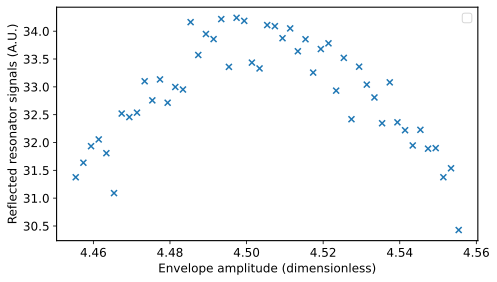

In [43]:
IQdata_round1 = np.load("./characterization/spectroscopy12/data/round1.pkl", allow_pickle=True)

fig, ax = plt.subplots(ncols=1, figsize=(7, 4))
# popt, yfit, pcov = ut.fit_function(frequencies_GHz, IQdata_round1, lambda x, A, T, phi, B: (A*np.cos(2*np.pi/T*x+phi)+B), [30, 0.6, 0, 0])
ax.scatter(frequencies_GHz, IQdata_round1, marker='x')
# ax.axvline(np.round(popt[1]/2,3), linestyle='--', label=r'$\tilde{\Omega}_0=$'+f'{np.round(popt[1]/2,3)}')
# ax.plot(amplitudes, yfit, linewidth=2)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
ax.set_ylabel('Reflected resonator signals (A.U.)', fontsize=12)
ax.set_xlabel('Envelope amplitude (dimensionless)', fontsize=12)
fig.tight_layout()
# fig.savefig('./calibrator/step1_rough_rabi/figs/rabi_osc12.png', dpi=300)

# Round 2 -- I apply a X pulse

In [18]:
backend_defaults = backend.defaults()
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit] + qubit_anharmonicty
frequency_span_Hz = 100 * 1e6
frequency_step_Hz = 2 * 1e6

# 25 each side
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2

frequencies_GHz = np.arange(frequency_min / 1e9, 
                            frequency_max / 1e9, 
                            frequency_step_Hz / 1e9)
  
drive_amp = 0.3
freq = qiskit.circuit.Parameter('freq')
with qiskit.pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.set_frequency(freq, drive_chan)
    qiskit.pulse.play(qiskit.pulse.Gaussian(duration=32,
                              sigma=8,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)
    
sweep_gate = qiskit.circuit.Gate("sweep", 1, [freq])

qc_sweep = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
qc_sweep.x(qubit)
qc_sweep.append(sweep_gate, [qubit])
qc_sweep.x(qubit)
qc_sweep.measure(qubit, cbit)
qc_sweep.add_calibration(sweep_gate, [qubit], sweep_sched, [freq])

frequencies_Hz = frequencies_GHz * 1e9
exp_sweep_circs = [qc_sweep.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]


In [39]:
num_shots_per_frequency = 2048

job_round2 = backend.run(exp_sweep_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_frequency)

print(job_round2.job_id())

csc0rjtdape00085tchg


In [53]:
job = provider.backend.retrieve_job('csc0rjtdape00085tchg')
exp = ut.DataAnalysis(experiment=job, average=True, shots=num_shots_per_frequency, qubit=0)
exp.retrieve_data(average=True)

with open("./characterization/spectroscopy12/data/round2.pkl", "wb") as f:
    pickle.dump(exp.IQ_data, f)

In [20]:
len(frequencies_GHz)

50

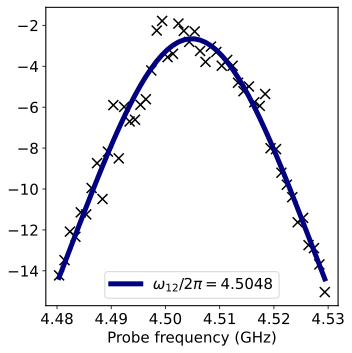

In [31]:
IQdata_round2 = np.load("./characterization/spectroscopy12/data/round2.pkl", allow_pickle=True)
IQdata_round2 = IQdata_round2[:-1]
fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
popt, yfit, pcov = ut.fit_function(frequencies_GHz,
                                 np.real(IQdata_round2), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [10, 4.5, 1, -4-10] # initial parameters for curve_fit
                                )
ax.scatter(frequencies_GHz, IQdata_round2, marker='x', color='black', s=100)
# ax.axvline(np.round(popt[1]/2,3), linestyle='--', label=r'$\tilde{\Omega}_0=$'+f'{np.round(popt[1]/2,3)}')
ax.plot(frequencies_GHz, yfit, linewidth=5, color='navy', label=r'$\omega_{12}/2\pi=$'+f'{np.round(popt[1],4)}')

ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=15)
# ax.set_ylabel('Reflected resonator signals (A.U.)', fontsize=12)
ax.set_xlabel('Probe frequency (GHz)', fontsize=15)
fig.tight_layout()
fig.savefig('./characterization/spectroscopy12/figs/spec12_shortpulse.png', dpi=600)

# Round 3

In [23]:
backend_defaults = backend.defaults()
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit] + qubit_anharmonicty
frequency_span_Hz = 50 * 1e6
frequency_step_Hz = 1 * 1e6

# 25 each side
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2

frequencies_GHz = np.arange(frequency_min / 1e9, 
                            frequency_max / 1e9, 
                            frequency_step_Hz / 1e9)
  
drive_amp = 0.15
freq = qiskit.circuit.Parameter('freq')
with qiskit.pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.set_frequency(freq, drive_chan)
    qiskit.pulse.play(qiskit.pulse.Gaussian(duration=120,
                              sigma=30,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)
    
sweep_gate = qiskit.circuit.Gate("sweep", 1, [freq])

qc_sweep = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
qc_sweep.x(qubit)
qc_sweep.append(sweep_gate, [qubit])
qc_sweep.x(qubit)
qc_sweep.measure(qubit, cbit)
qc_sweep.add_calibration(sweep_gate, [qubit], sweep_sched, [freq])

frequencies_Hz = frequencies_GHz * 1e9
exp_sweep_circs = [qc_sweep.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]


In [48]:
num_shots_per_frequency = 2048

job_round2 = backend.run(exp_sweep_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_frequency)

print(job_round2.job_id())

csc7dk63dkhg008zervg


In [54]:
job = provider.backend.retrieve_job('csc7dk63dkhg008zervg')
exp = ut.DataAnalysis(experiment=job, average=True, shots=num_shots_per_frequency, qubit=0)
exp.retrieve_data(average=True)

with open("./characterization/spectroscopy12/data/round3.pkl", "wb") as f:
    pickle.dump(exp.IQ_data, f)

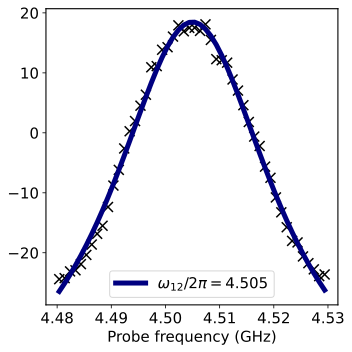

In [32]:
IQdata_round3 = np.load("./characterization/spectroscopy12/data/round3.pkl", allow_pickle=True)

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
popt, yfit, pcov = ut.fit_function(frequencies_GHz,
                                 np.real(IQdata_round3), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [10, 4.5, 1, -4-10] # initial parameters for curve_fit
                                )
ax.scatter(frequencies_GHz, IQdata_round3, marker='x', color='black', s=100)
# ax.axvline(np.round(popt[1]/2,3), linestyle='--', label=r'$\tilde{\Omega}_0=$'+f'{np.round(popt[1]/2,3)}')
ax.plot(frequencies_GHz, yfit, linewidth=5, color='navy', label=r'$\omega_{12}/2\pi=$'+f'{np.round(popt[1],4)}')

ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=15)
# ax.set_ylabel('Reflected resonator signals (A.U.)', fontsize=12)
ax.set_xlabel('Probe frequency (GHz)', fontsize=15)
fig.tight_layout()
fig.savefig('./characterization/spectroscopy12/figs/spec12_longpulse.png', dpi=600)